In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit  # import the curve fitting function
from scipy.special import factorial
%matplotlib inline

# Day 1

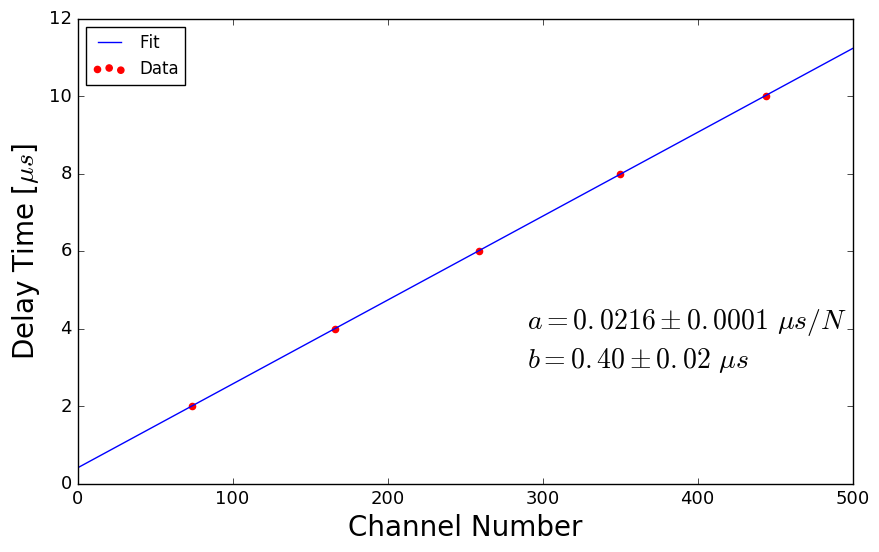

In [90]:
#Lets determine scale from channel calibration

x = np.array([94, 186, 279, 370, 464]) #Channels
x = x-20 #Measurement issues
t = np.array([2, 4, 6, 8, 10]) #Delay in us

#Fitting
def myfun(x,a,b):
    ans =  a*x + b
    return ans

p0 = [0.216,0.4] #guess

xspace = np.linspace(0,500,1000) #FIX?

plsq, pcov = curve_fit(myfun, x, t, p0)  # curve fit returns p and covariance matrix
# these give the parameters and the uncertainties

a= plsq[0]
ea = np.sqrt(pcov[0,0])

b = plsq[1] #microseconds
eb = np.sqrt(pcov[1,1]) #microseconds


yfit = myfun(xspace,plsq[0],plsq[1])  # use fit results for a, b, c


plt.figure(figsize=(10,6));
#plt.scatter(Channels,Counts);

plt.scatter(x,t,color='red',label='Data');

plt.plot(xspace,yfit,label='Fit')

plt.legend(loc='upper left')

plt.xlabel('Channel Number',fontsize=20);
plt.ylabel('Delay Time [$\mu s$]',fontsize = 20);
plt.xticks(size = 13);
plt.yticks(size = 13);

plt.xlim(0,500)
plt.ylim(0,12)

plt.text(290,4,'$a = %.4f \pm %.4f$ $\mu s / N$' % (a,ea),size=20)
plt.text(290,3,'$b = %.2f \pm %.2f$ $\mu s$ ' % (b,eb),size=20)


plt.savefig('Calibration.png')

In [98]:
np.sum(Counts)

1831

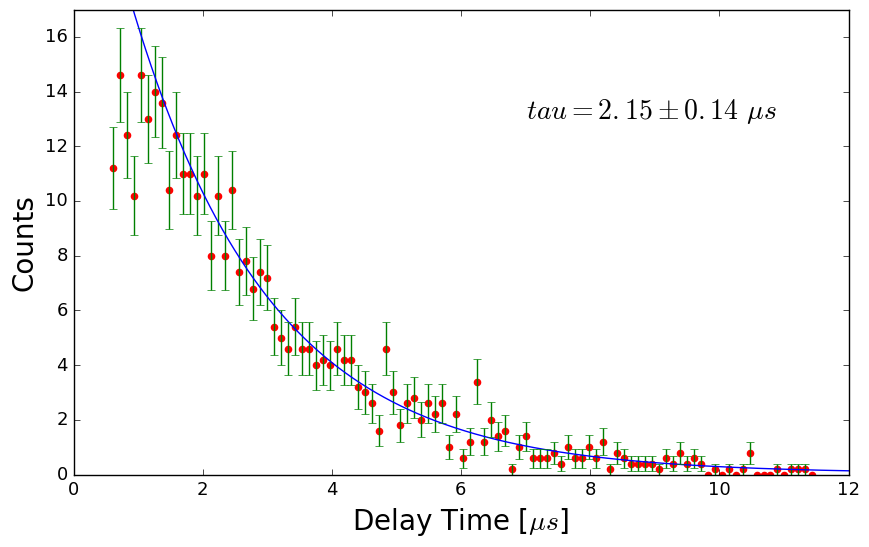

In [97]:
Day1 = pd.read_excel('DecayData.xlsx',sheetname = None, header = None)

Channels = np.arange(0,512) #Channel Number
Counts = np.array([entry for entry in Day1['Sheet1'][0]]) #Counts

#We want to group Counts

N = 5
GroupedChannels = np.arange(0,512,N)


GroupedCounts = np.array([np.mean(Counts[i:i+N]) for i in GroupedChannels])

#(1/N)*SQRT(Sum of Squares of Individual Uncertainties)

GroupedUncertainties = np.array([(1/N)*np.sqrt(np.sum(Counts[i:i+N])) for i in GroupedChannels])

GroupedTimes = GroupedChannels*a + b #Need to determine Scale above [Scale] = microseconds/channel

GroupedCountsALL = GroupedCounts[2:]
GroupedUncertaintiesALL = GroupedUncertainties[2:]
GroupedTimesALL = GroupedTimes[2:]



#Lop off first two entries
I = 15
F = -1

GroupedCounts = GroupedCounts[I:F]
GroupedUncertainties = GroupedUncertainties[I:F]
GroupedTimes = GroupedTimes[I:F]


#Fitting
def myfun(t,No,tau,c):
    ans =  No*np.exp(-t/tau) + c
    return ans

p0 = [20,2,0.1] #guess

xspace = np.linspace(0,12,1000)

plsq, pcov = curve_fit(myfun, GroupedTimes, GroupedCounts, p0)  # curve fit returns p and covariance matrix
# these give the parameters and the uncertainties

No= plsq[0]
eNo = np.sqrt(pcov[0,0])

tau = plsq[1] #microseconds
etau = np.sqrt(pcov[1,1]) #microseconds

c = plsq[2]
ec = np.sqrt(pcov[2,2])

yfit = myfun(xspace,plsq[0],plsq[1],plsq[2])  # use fit results for a, b, c




plt.figure(figsize=(10,6));
#plt.scatter(Channels,Counts);

plt.plot(xspace,yfit)

plt.scatter(GroupedTimesALL,GroupedCountsALL,color='red');
plt.errorbar(GroupedTimesALL,GroupedCountsALL, yerr= GroupedUncertaintiesALL,fmt='None')

plt.xlabel('Delay Time [$\mu s$]',fontsize=20);
plt.ylabel('Counts',fontsize = 20);
plt.xticks(size = 13);
plt.yticks(size = 13);

plt.xlim(0,12)
plt.ylim(0,17)

plt.text(7,13,'$tau = %.2f \pm %.2f$ $\mu s$ ' % (tau,etau),size=20)


plt.savefig('Day1.png')

In [99]:
np.sum(GroupedTimesALL*GroupedCountsALL)/np.sum(GroupedCountsALL)

2.8279395571155583

# Day 2

In [92]:
def chi2(ymeasured,ytheory):
    # N = number of bins
    # ymeasured = Array of the measured number of counts in each bin
    # ytheory = Array of the predicted number of counts in each bin
    
    N = len(ymeasured)
    sigma = np.sqrt(ymeasured)
    for i in np.arange(0,N):
        if sigma[i] == 0:
            sigma[i] = 1
    
    
    
    return (1/N)*np.sum(np.array([((ymeasured[i]-ytheory[i])/sigma[i])**2 for i in np.arange(0,N)]))

In [96]:
Counts.shape

(512,)

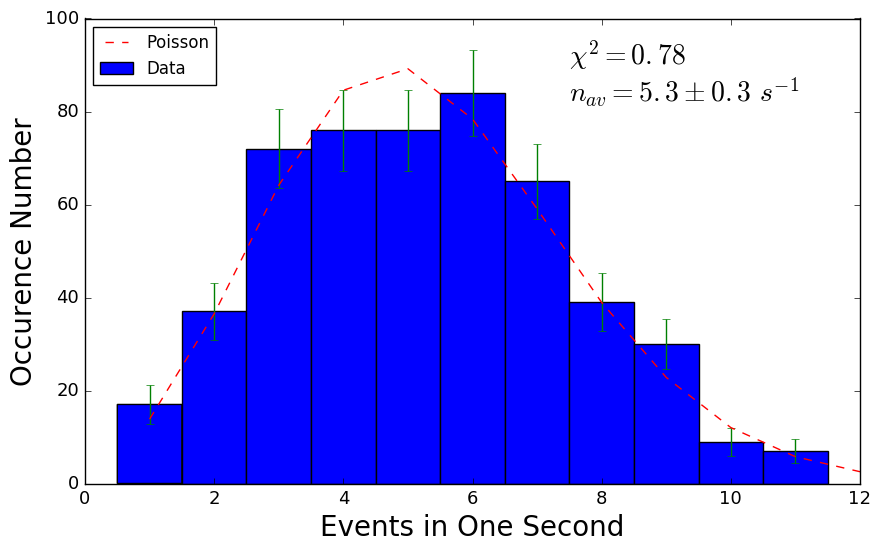

In [110]:
Day2 = pd.read_excel('ArrivalData.xlsx',sheetname = None, header = None)


#Read in
Channels = np.arange(0,512) #Channel Number
Counts = np.array([entry for entry in Day2['Sheet1'][0]]) #Counts

#Initiate Hist
plt.figure(figsize=(10,6));
n, bins, patches =  plt.hist(Counts,bins=11,align='left',label='Data')

#Uncertainties
nerr = np.sqrt(n)
plt.errorbar(np.arange(1,12), n, yerr = nerr ,fmt='None')


#Poisson Distribution
def poisson(k,mu):
    return np.exp(-mu) * mu**k / factorial(k,0)

mu = np.mean(Counts)
y = poisson(bins, mu)
l = plt.plot(bins, y*512, 'r--', linewidth=1,label='Poisson')

#Chi Squared
no = np.sum(bins[0:11]*n)/np.sum(n)


noerr = np.sqrt(np.sum((bins[0:11]**2)*n))/np.sum(n)

X2 = chi2(n,y*512)

plt.text(7.5,90,'$\chi^2 = %.2f$ ' % (X2),size=20)
plt.text(7.5,82,'$n_{av} = %.1f \pm %.1f$ $s^{-1}$ ' % (no,noerr),size=20)


plt.xlabel('Events in One Second',fontsize=20);
plt.ylabel('Occurence Number',fontsize = 20);
plt.xticks(size = 13);
plt.yticks(size = 13);

plt.xlim(0,12);

plt.legend(loc='upper left')


plt.savefig('Day2.png')

In [102]:
binsthin = bins[0:11]**2

In [103]:
binsthin

array([   1.,    4.,    9.,   16.,   25.,   36.,   49.,   64.,   81.,
        100.,  121.])